Условия: финансовые показатели заказчика: агентства недвижимости, посредственные, из-за низкого качества анализа риэлторами рынка недвижимости и низкого количества выгодных предложений.

Цель - разработать модель предсказания стоимости домов, которая позволила бы обойти конкурентов по скорости и качеству совершения сделок.

Задача - разработать сервис для предсказания стоимости домов на основе истории предложений.

In [234]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
%matplotlib inline
plt.style.use('seaborn')

In [329]:
data = pd.read_csv('data/data.csv')
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


status - for sale - 156104, For sale - 43465 продается, Active - 105207 - активное - очистка от других значений - используем в модели
private pool - частный бассейн, Yes - 4181, остальные пропуски - удаление признака
propertyType  - тип дома: single-family home - 92206, Single Family - 62869, Single Family Home - 31728 condo - 25968, unique 1280 -предобработка и очистка от других значений - используем в модели
street - улица, unique - 337076, в топ 5 входят записи, в которых адрес не разглашается - удаление
baths - количество ванн - предобработка, удаление признака
homeFacts - факты о доме, содержит год постройки, год реконструкции, отопление, охлаждение, парковка, фактическая цена кв метра - предобработка
fireplace - наличие камина - предобработка, удаление признака
city - город, предобработка, не используем в модели
schools - школа, содержит название - предобработка, удаление
sqft - площадь - предобработка, очистка в первую очередь. - используем в модели
zipcode - почтовый индекс - делит населенный пункт на районы - используем в модели
beds - спальни - предобработка, удаление
state - штат, используем в модели
stories - описание
mls-id - идентификатор списка/агента по продажам, удаление
PrivatePool - частный бассейн, Yes - 11518, yes - 28793, остальные пропуски - удаление
target - цена, целевой признак - предобработка - используем в модели

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [330]:
data['target'] = data['target'].astype('str')
def get_target(arg):#удаляем знак '$' из значений
    if '$' in arg: return arg[1::]
    else: return arg
data['target'] = data['target'].apply(get_target)
data['target'] = data['target'].astype('str')
def get_target1(arg):#удаляем значения со знаком '+'
    if '+' in arg: return 0
    else: return arg
data['target'] = data['target'].apply(get_target1)
data['target'] = data['target'].astype('str')
def get_target2(arg):#удаляем значения со знаком '-'
    if '-' in arg: return 0
    else: return arg
data['target'] = data['target'].apply(get_target2)
data['target'] = data['target'].astype('str')
def get_target3(arg):#удаляем значения со знаком '/mo'
    if '/mo' in arg: return 0
    else: return arg
data['target'] = data['target'].apply(get_target3)
data['target'] = data['target'].astype('str')
def get_target4(arg):#удаляем значения 'nan' 
    if 'nan' in arg: return 0
    else: return arg
data['target'] = data['target'].apply(get_target4)

In [332]:
data['target'] = data['target'].astype('str')
def get_float(arg):#используем функцию для преобразование объекта в значение float
    if ',' in arg: return arg.replace(',','')#для этого запятую в значении, отделяющим тысячи, удаляем
    else: return arg#возвращаем значение без запятых
data['target'] = data['target'].apply(get_float)

In [333]:
data['target'] = data['target'].fillna(data['target'] == '0')#заменяем пропуски на 0
list = ['0']
data = data[data.target.isin(list) == False]#убираем строки содержащие стоимость = 0
data.shape

(367043, 18)

In [334]:
data['target'] = data['target'].astype('int64')#преобразовываем тип данных в числовой целочислительный

<AxesSubplot:>

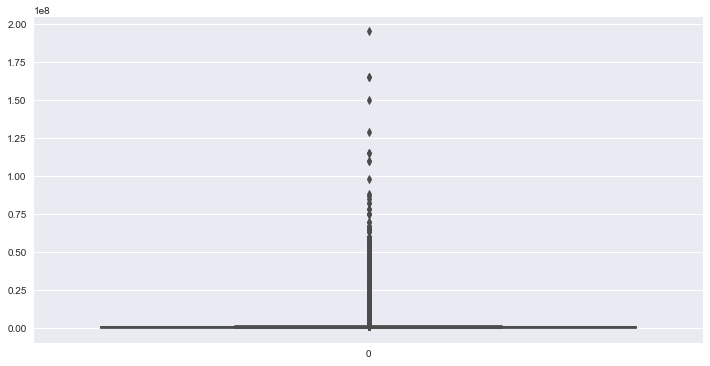

In [335]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=data['target'], ax=ax)

In [336]:
data['target'].describe()

count    3.670430e+05
mean     6.494312e+05
std      1.858641e+06
min      1.000000e+00
25%      1.850000e+05
50%      3.200000e+05
75%      5.890000e+05
max      1.950000e+08
Name: target, dtype: float64

In [337]:
# удалим все выбросы для признака target
q1 = data.target.quantile(0.25)
q3 = data.target.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (iqr * 1.5)
upper_bound = q3 + (iqr * 1.5)
print(q1, q3, iqr, lower_bound, upper_bound)

data = data[(data['target'] >= lower_bound) & (data['target'] <= upper_bound)]
data.shape

185000.0 589000.0 404000.0 -421000.0 1195000.0


(329863, 18)

<AxesSubplot:>

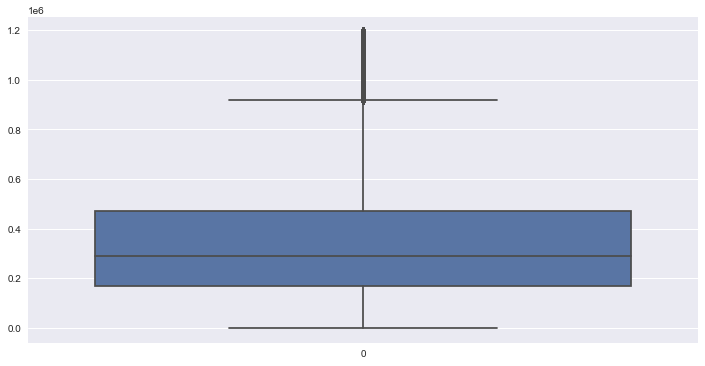

In [339]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=data['target'], ax=ax)

In [340]:
data['sqft'] = data['sqft'].fillna(data['sqft'] == 0)#заменяем пропуски на 0
list = [0]
data = data[data.sqft.isin(list) == False]#оставляем строки не содержащие значение площади равной 0
data.shape

(295299, 18)

In [341]:
data['sqft'].unique()

array(['2900', '1,947 sqft', '897 sqft', ..., '4371', '13,870 sqft',
       'Total interior livable area: 4,615 sqft'], dtype=object)

In [342]:
data['sqft'] = data['sqft'].astype('str')
def get_sqft(arg):#убираем из значений 'sqft'
    if 'sqft' in arg: return arg[::-1][5::][::-1]#убираем из значений 'sqft'
    else: return arg
data['sqft'] = data['sqft'].apply(get_sqft)
data['sqft'] = data['sqft'].astype('str')
def get_sqft1(arg):#убираем убираем значения с 'str'
    if 'e' in arg: return 0
    else: return arg
data['sqft'] = data['sqft'].apply(get_sqft1)
data['sqft'] = data['sqft'].astype('str')
def get_sqft2(arg):#убираем значения с '--'
    if '--' in arg: return 0
    else: return arg
data['sqft'] = data['sqft'].apply(get_sqft2)

In [343]:
data['sqft'] = data['sqft'].astype('str')
def get_sq(arg):
    if ',' in arg: return arg.replace(',', '')#убираем из значения площади, запятые отдельющие тысячи
    elif '-' in arg: return 0#убираем значение площади, содержащие '-'
    else: return arg
data['sqft'] = data['sqft'].apply(get_sq)

In [344]:
data['sqft'] = data['sqft'].astype('int64')#преобразовываем тип данных в числовой целочислительный

<AxesSubplot:>

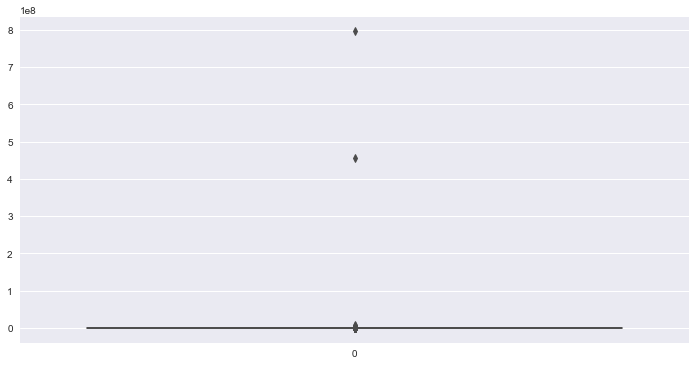

In [345]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=data['sqft'], ax=ax)

In [346]:
data['sqft'].describe()

count    2.952990e+05
mean     6.664800e+03
std      1.688855e+06
min      0.000000e+00
25%      1.052000e+03
50%      1.600000e+03
75%      2.300000e+03
max      7.959794e+08
Name: sqft, dtype: float64

In [351]:
def get_sq(arg):#используем функцию для удаления выбросов
    if  400 < arg < 2342: return arg
    else: return 0
data['sqft'] = data['sqft'].apply(get_sq)

In [352]:
list = [0]
data = data[data.sqft.isin(list) == False]#оставляем строки содержащие площадь > 0
data.shape

(190172, 18)

In [353]:
data['sqft'].describe()

count    190172.000000
mean       1476.052405
std         459.373821
min         401.000000
25%        1119.000000
50%        1467.000000
75%        1842.000000
max        2341.000000
Name: sqft, dtype: float64

In [259]:
data['sqft'].unique()

array([1947, 1930, 2203, ..., 2119, 1287, 1401], dtype=int64)

In [260]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87904 entries, 1 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        75918 non-null  object
 1   private pool  0 non-null      object
 2   propertyType  82447 non-null  object
 3   street        87904 non-null  object
 4   baths         74673 non-null  object
 5   homeFacts     87904 non-null  object
 6   fireplace     25355 non-null  object
 7   city          87904 non-null  object
 8   schools       87904 non-null  object
 9   sqft          87904 non-null  int64 
 10  zipcode       87904 non-null  object
 11  beds          75970 non-null  object
 12  state         87904 non-null  object
 13  stories       62235 non-null  object
 14  mls-id        1747 non-null   object
 15  PrivatePool   8427 non-null   object
 16  MlsId         77072 non-null  object
 17  target        87904 non-null  int64 
dtypes: int64(2), object(16)
memory usage: 14.8+ M

In [354]:
data['propertyType'].value_counts()#предобработка типа недвижимости

single-family home                                             50595
Single Family                                                  24934
condo                                                          20451
Single Family Home                                             19031
Condo                                                          11218
                                                               ...  
Colonial, High Rise, Ranch                                         1
1 Story, Historic/Older, Other (See Remarks)                       1
1 1/2 Story with Basement, Cape Cod                                1
2 Stories, Historic/Older, Victorian                               1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 823, dtype: int64

In [355]:
data['propertyType'].unique()

array(['single-family home', 'townhouse', 'Florida', 'Single Family',
       'coop', nan, 'multi-family', 'Penthouse, Split-Level',
       'Multi-Family Home', 'Condo', 'condo', 'Single Family Home',
       'lot/land', ' ', '1 Story, Ranch', 'Other Style', 'High Rise',
       'mobile/manufactured', 'Condo/Townhome/Row Home/Co-Op',
       'Detached, One Story', 'Townhouse', 'Single Detached, Traditional',
       '1 Story, Traditional', 'Traditional', 'Cooperative',
       'Contemporary/Modern', 'Mobile / Manufactured', 'Mfd/Mobile Home',
       '2 Story', '1 Story', 'Contemporary', 'Multi-Level, Modern',
       'Condo/Unit', '2 Stories, Traditional', 'Ranch',
       'Low-Rise (1-3 Stories)', 'Rancher, Raised Ranch',
       'Bungalow, Cape Cod', 'Single Detached', 'Colonial', 'Two Story',
       'Garden Home', 'Bungalow', 'A-Frame', 'Federal',
       'Attached or 1/2 Duplex, Traditional', '2 Stories',
       'Garden Home, Tri-Level', 'Spanish/Mediterranean',
       'Single Detached, Tudo

In [356]:
data['propertyType'].astype('str')
list = ['single-family home', 'Single Family','Single Family Home']
list1 = ['condo', 'Condo', 'Condo/']
list2 = ['townhouse', 'Townhouse']
def get_property_type(arg):
    if arg in list: return 'Single Family Home'
    elif arg in list1: return 'Condo'
    elif arg in list2: return 'Townhouse'
    else: return 'other'
data['propertyType'] = data['propertyType'].apply(get_property_type)

In [357]:
list = ['other']
data = data[data.propertyType.isin(list) == False]#оставляем строки не содержащие значение типа дома - другой
data.shape

(139198, 18)

In [358]:
data['status'].value_counts()#предобработка статуса объявлений

for sale                      75083
For sale                      14794
Active                        13467
foreclosure                    4447
Pending                        2489
                              ...  
Pending   Continue To Show        1
Pending (Do Not Show)             1
Temporary Active                  1
Pending Bring Backup              1
Accepting backups                 1
Name: status, Length: 85, dtype: int64

In [359]:
data['status'].unique()

array(['for sale', nan, 'For sale', 'Pending', 'Active', ' / auction',
       'New construction', 'Under Contract   Showing', 'P',
       'Under Contract', 'Under Contract Backups', 'foreclosure',
       'Option Pending', 'Active Under Contract', 'A Active',
       'Contingent', 'Foreclosed', 'Under Contract Show', 'New',
       'Contingent Finance And Inspection', 'Pre-foreclosure',
       'P Pending Sale', 'Active With Contingencies',
       'Contingent Take Backup', 'Option Contract',
       'Pending Continue To Show', 'pending', 'C',
       'Pre-foreclosure / auction', 'Contingent Show',
       'Contingent   Show', 'Pi', 'Contract Contingent On Buyer Sale',
       'U Under Contract', 'Active Contingency',
       'Pending With Contingencies', 'Pending Bring Backup', 'Auction',
       'Pending Taking Backups', 'Price Change', 'Foreclosure',
       'C Continue Show', 'Contingency Contract', 'Contingent Escape',
       'Active/Contingent', 'Active Backup', 'Active With Offer',
       '

In [360]:
list = ['for sale', 'For sale']
list1 = ['Active', 'active', 'A Active', 'Active Contingent', 'Active/Contingent']

def get_status(arg):
    if arg in list: return 'For sale'
    elif arg in list1: return 'Active'
    else: return 'other'
data['status'] = data['status'].apply(get_status)

In [361]:
list = ['other']
data = data[data.status.isin(list) == False]#оставляем строки не содержащие сомнительные объявления
data.shape

(103586, 18)

In [362]:
data['homeFacts'].unique()#предобработка фактов о доме, извлечение года постройки

array(["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}",
       "{'atAGlanceFacts': [{'factValue': '1920', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '680 sqft', 'factLabel': 'lotsize'}, {'factValue': '$233/sqft', 'factLabel': 'Price/sqft'}]}",
       "{'atAGlanceFacts': [{'factValue': '1989', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced air', 'factLabel': 'Heating'}, {'factValue': 'Central, Evaporative', 'factLabel': 'Cooling'}, {'fact

In [363]:
data['Year1'] = data['homeFacts'].apply(lambda x: x.split('Year built')[0])#выбираем строку до интересуемого признака
data['Year2'] = data['Year1'].apply(lambda x: x.split(',')[0])#оставляем запись до первой запятой, в конце получившейся записи остается дата
data['Year_built'] = data['Year2'].apply(lambda x: x.split('factValue')[-1][4:8])#оставляем запись года строительства здания
data['Year_built'].head()

1     2019
5     1920
20    1989
24    2014
32    1977
Name: Year_built, dtype: object

In [364]:
data = data.drop(['Year1', 'Year2'], axis=1)#удаляем вспомагательные столбцы

In [365]:
data['Year_built'] = data['Year_built'].astype('str')
list = ["'", "N"]
def get_Year_built(arg):
    if arg[0] in list: return 0#убираем из значения запятые
    else: return arg
data['Year_built'] = data['Year_built'].apply(get_Year_built)

In [366]:
data['Year_built'] = data['Year_built'].astype('int64')#преобразовываем тип данных в числовой целочислительный

In [367]:
data['Year_built'].min()

0

In [368]:
def get_Year(arg):
    if 1950 < arg < 2023: return arg#убираем не интересующие значения
    else: return 0
data['Year_built'] = data['Year_built'].apply(get_Year)

In [369]:
list = [0]
data = data[data.Year_built.isin(list) == False]#убираем строки содержащие стоимость = 0
data.shape

(75319, 19)

In [370]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75319 entries, 1 to 377179
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        75319 non-null  object
 1   private pool  0 non-null      object
 2   propertyType  75319 non-null  object
 3   street        75319 non-null  object
 4   baths         67071 non-null  object
 5   homeFacts     75319 non-null  object
 6   fireplace     22420 non-null  object
 7   city          75319 non-null  object
 8   schools       75319 non-null  object
 9   sqft          75319 non-null  int64 
 10  zipcode       75319 non-null  object
 11  beds          69400 non-null  object
 12  state         75319 non-null  object
 13  stories       54593 non-null  object
 14  mls-id        2644 non-null   object
 15  PrivatePool   12706 non-null  object
 16  MlsId         71536 non-null  object
 17  target        75319 non-null  int64 
 18  Year_built    75319 non-null  int64 
dtypes: 

In [371]:
dt = data.drop(['private pool', 'street', 'baths', 'homeFacts', 'fireplace', 'schools', 'beds', 'stories', 'mls-id', 'PrivatePool', 'MlsId'], axis=1)#удаляем неинформативные столбцы

In [372]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75319 entries, 1 to 377179
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        75319 non-null  object
 1   propertyType  75319 non-null  object
 2   city          75319 non-null  object
 3   sqft          75319 non-null  int64 
 4   zipcode       75319 non-null  object
 5   state         75319 non-null  object
 6   target        75319 non-null  int64 
 7   Year_built    75319 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 5.2+ MB


In [373]:
dt.duplicated().sum()#находим дубликаты строк

4083

In [374]:
dt.drop_duplicates(inplace= True)#удаляем дубликаты строк
dt.shape

(71236, 8)

Определяем интересующие нас признаки недвижимости, для подготовки модели

status -категориальный
propertyType - 'Single Family Home', 'Condo', 'Townhouse' - категориальный
sqft - числовой
zipcode - категориальный
state - категориальный
Year_built - числовой
target - целевая переменная - числовой

ПОДГОТАВЛИВАЕМ ДАТАСЕТ

In [387]:
df = dt.copy()

In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71236 entries, 1 to 377179
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        71236 non-null  object
 1   propertyType  71236 non-null  object
 2   city          71236 non-null  object
 3   sqft          71236 non-null  int64 
 4   zipcode       71236 non-null  object
 5   state         71236 non-null  object
 6   target        71236 non-null  int64 
 7   Year_built    71236 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 4.9+ MB


In [388]:
df['status'] = df['status'].astype('str')
df['propertyType'] = df['propertyType'].astype('str')
df['sqft'] = df['sqft'].astype('int32')
df['city'] = df['city'].astype('str')
df['state'] = df['state'].astype('str')
df['target'] = df['target'].astype('int32')
df['zipcode'] = df['zipcode'].astype('str')
df['Year_built'] = df['Year_built'].astype('int16')

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71236 entries, 1 to 377179
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        71236 non-null  object
 1   propertyType  71236 non-null  object
 2   city          71236 non-null  object
 3   sqft          71236 non-null  int32 
 4   zipcode       71236 non-null  object
 5   state         71236 non-null  object
 6   target        71236 non-null  int32 
 7   Year_built    71236 non-null  int16 
dtypes: int16(1), int32(2), object(5)
memory usage: 3.9+ MB


In [288]:
df['state'].value_counts()

FL    13167
TX     8640
NV     2381
TN     2354
NC     2303
CA     1316
WA     1239
GA      880
IL      737
AZ      712
OH      572
CO      501
OR      394
NY      373
PA      256
IN      215
MI      170
UT      164
MD      111
VT       96
DC       52
MO       39
MA       26
VA       20
IA       18
NJ       14
WI       12
ME        8
KY        7
OK        4
SC        3
MS        1
Name: state, dtype: int64

In [390]:
list = ['FL', 'TX', 'NC', 'TN', 'NV', 'CA', 'WA', 'OH', 'GA', 'IL']
def get_state(arg):#оставляем популярные штаты
    if arg in list: return arg#
    else: return 'other'
df['state'] = df['state'].apply(get_state)

In [391]:
list = ['other']
df = df[df.state.isin(list) == False]#оставляем строки не содержащие не популярные штаты
data.shape

(75319, 19)

In [392]:
categorical_columns_names = ['status', 'propertyType', 'state', 'zipcode']
encoded_columns = pd.get_dummies(df, columns = categorical_columns_names)#кодируем категориальные признаки

In [393]:
df = encoded_columns
df.head()

,city,sqft,target,Year_built,status_Active,status_For sale,propertyType_Condo,propertyType_Single Family Home,propertyType_Townhouse,state_CA,...,zipcode_99208,zipcode_99212,zipcode_99216,zipcode_99217,zipcode_99218,zipcode_99223,zipcode_99224,zipcode_99336,zipcode_99337,zipcode_99338
1,Spokane Valley,1947,310000,2019,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
20,Palmdale,1731,375000,1989,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
24,Killeen,1953,182000,2014,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32,Pt Saint Lucie,1176,204800,1977,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
34,Jacksonville,864,105000,1963,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33589 entries, 1 to 377175
Columns: 1814 entries, city to zipcode_99338
dtypes: int16(1), int32(2), object(1), uint8(1810)
memory usage: 58.8+ MB


In [394]:
X = df.drop(['target', 'city'], axis=1)
y = df['target']

In [395]:
from sklearn import model_selection
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=40 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (50375, 2238)
Test shape: (12594, 2238)


In [396]:
from sklearn import metrics

def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))#коэффициент детерминации
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))#средняя абсолютная ошибка (целевая метрика)
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))#средняя абсолютная ошибка в процентах
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))#коэффициент детерминации
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))#средняя абсолютная ошибка (целевая метрика)
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))#средняя абсолютная ошибка в процентах

In [397]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()

In [398]:
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)

LinearRegression()

In [399]:
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)

In [400]:
y_test_pred = lr.predict(X_test)

In [401]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.753
Train MAE: 62150.606
Train MAPE: 23.758


Test R^2: -249651098827578.531
Test MAE: 125045194154.710
Train MAPE: 72419555.262


In [402]:
from sklearn import preprocessing
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Инициализируем объект класса линейная регрессия
sgd_lr = linear_model.SGDRegressor(random_state=42)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

c:\Users\SEMEN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Train R^2: 0.720
Train MAE: 66022.122
Train MAPE: 24.843


Test R^2: 0.708
Test MAE: 67537.149
Train MAPE: 24.786


In [403]:
#создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train)

#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()

In [404]:
#Обучаем модель предсказывать логарифм целевого признака
lr.fit(X_train, y_train_log)

LinearRegression()

In [405]:
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))

C:\Users\SEMEN\AppData\Local\Temp\ipykernel_5212\1268739094.py:4: RuntimeWarning: overflow encountered in exp
  y_test_pred = np.exp(lr.predict(X_test))


In [406]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.763
Train MAE: 56607.883
Train MAPE: 19.498




ValueError: Input contains infinity or a value too large for dtype('float64').

In [407]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [408]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(ridge_lr_poly.predict(X_train_scaled))
y_test_pred = np.exp(ridge_lr_poly.predict(X_test_scaled))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.758
Train MAE: 57371.930
Train MAPE: 19.749


Test R^2: 0.738
Test MAE: 60009.156
Train MAPE: 19.998


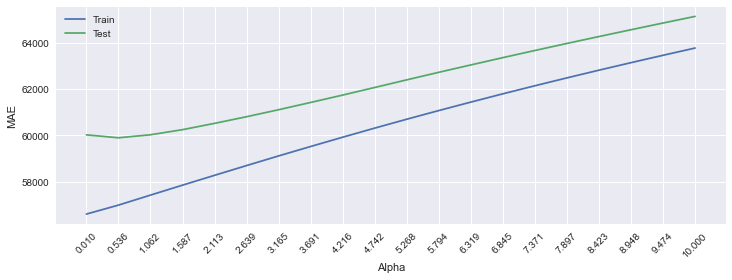

In [409]:
#Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.01, 10, 20)
#Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=10000)
    #Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_scaled, y_train_log)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_scaled))
    y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_scaled))
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))

#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

In [410]:
#Создаем объект класса линейная регрессия с L2-регуляризацией
#Выставляем параметр alpha в подобранное выше значение
ridge_lr = linear_model.Ridge(alpha=0.01)
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr.fit(X_train_scaled, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(ridge_lr.predict(X_train_scaled))
y_test_pred = np.exp(ridge_lr.predict(X_test_scaled))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.763
Train MAE: 56604.838
Train MAPE: 19.498


Test R^2: 0.737
Test MAE: 60026.129
Train MAPE: 19.974


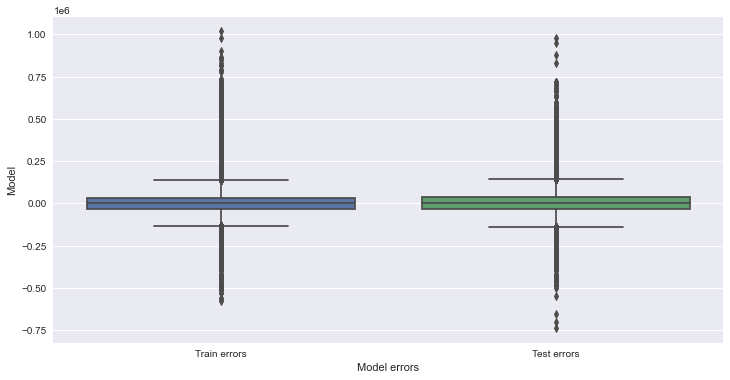

In [411]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax) 
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [413]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor


regr1 = DecisionTreeRegressor(
    max_depth=20, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
regr1.fit(X_train, y_train)


 
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева
regr2 = RandomForestRegressor(
    max_depth=20, #максимальная глубина дерева
    n_estimators=10, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
regr2.fit(X_train, y_train)


# Формируем предсказания каждой из моделей
y_pred1 = regr1.predict(X_test)
y_pred2 = regr2.predict(X_test)
 
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для решающего дерева {round(mean_squared_error(y_test, y_pred1), 2)}')
print(f'Качество предсказания по MSE для случайного леса  {round(mean_squared_error(y_test, y_pred2), 2)}')

Качество предсказания по MSE для решающего дерева 15313370903.91
Качество предсказания по MSE для случайного леса  12986194036.4


In [418]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]
# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=RandomForestRegressor( #метамодель
        n_estimators=30, #количество деревьев в ансамбле                    
        random_state=42 #датчик генератора случайных чисел
    )
)
# Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV()),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=50,
                                                        random_state=42))

In [419]:
# Формируем предсказания каждой из моделей
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.856
Train MAE: 44922.858
Train MAPE: 16.912


Test R^2: 0.750
Test MAE: 61326.544
Train MAPE: 22.188


In [416]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack), 2)}')

Качество предсказания по MSE для стекинга 9232921453.67


In [417]:
from sklearn.ensemble import AdaBoostRegressor

# Создаем объект класса дерева решений
dt = DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    base_estimator=dt, #базовая модель
    random_state=42, #датчик генератора случайных чисел
    n_estimators=10 #количество моделей в ансамбле
)
# Обучаем модель
ada.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
ada_pred  = ada.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, ada_pred),2)}')

Качество предсказания по MSE для AdaBoost 26128968138.42


In [324]:
# Формируем предсказания каждой из моделей
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.128
Train MAE: 76678.521
Train MAPE: 27.342


Test R^2: 0.124
Test MAE: 77185.774
Train MAPE: 27.463


In [325]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=3, #максимальная глубина дерева
    n_estimators=10, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для GradientBoostingRegressor {round(mean_squared_error(y_test, gb_pred),2)}')


Качество предсказания по MSE для GradientBoostingRegressor 8199496780.25


In [326]:
# Формируем предсказания каждой из моделей
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.153
Train MAE: 72743.446
Train MAPE: 24.477


Test R^2: 0.147
Test MAE: 73109.429
Train MAPE: 24.553


In [327]:
def rmse(y_hat, y):
    return mean_squared_error(y_hat, y, squared = False)

In [420]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [421]:
from sklearn.metrics import r2_score

y_pred = pipeline.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по метрике R2: 0.7392
Качество по RSME: 97859.6933


основные итоги работы

Лучший результат показала модель со стекингом.
Вместе с тем, прогноз осложнялся разнородными данными.
За основные данные взяты площадь здания, цена, в первую очередь.
Тип объявления - так как компании интересны объявления о продаже недвижимости, активные объявления (срочные), без авантюр в виде залоговой недвижимости, аукциона и т.п.
Вид недвижимости, определяющий ее класс.
Отельного внимания заслуживает zipcode - почтовый индекс, которые показывает город и район расположения недвижимости.
Полученные метрики на стеке оцениваю как допустимые, при таких разнородных данных.
Манипуляции с количеством ванн, кроватей, года реконструкции, вида отопления, охлаждения, парковки не возымели эффекта, компьютер раз 20 приходилось вынужденно отключать из-за зависания. Город оставил в датафрейме больше для описания.
По факту для большой компании должен иметь принцип разделения по штатам, так увеличит точность предсказания модели.

P.S. насколько ненавидил функции, на столько разобрался в них (в том числе используя дополнительную литературу) и полюбил)))
До свидания!